In [20]:
import json
import re
import numpy as np
import cv2
# darkflow expect each image comes with one annotation file in the format of 
# [category number] [object center in X] [object center in Y] [object width in X] [object width in Y]
# We need to convert our annotation file into that format
# In our annotation file［box_upper_left_x, box_upper_left_y, box_lower_right_x, box_lower_right_y, class_label]


output_dir = 'training/'
input_file1 = "./sub_training/label-newLeft.idl"
input_file2 = "./sub_training/label-newRight.idl"
with open(input_file1) as f:
    lines1 = f.readlines()
with open(input_file2) as f:
    lines2 = f.readlines()

boxes = {1:[],2:[],3:[],20:[]}
cnt = [0,0,0,0]  # counting for each classes
    
for each in lines1:
    line = json.loads(each)  
    if not list(line.values())[0]: # no annotation for this image
        continue
    else:
        for box in list(line.values())[0]:
            label = box[4]
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]
            msg = [xmin,xmax,ymin,ymax]
            boxes[label].append(msg)
# check statistics for new left
#for box in boxes.values():
#    print(len(box))
    

for each in lines2:
    line = json.loads(each)  
    if not list(line.values())[0]: # no annotation for this image
        continue
    else:
        for box in list(line.values())[0]:
            label = box[4]
            xmin = box[0]
            ymin = box[1]
            xmax = box[2]
            ymax = box[3]
            msg = [xmin,xmax,ymin,ymax]
            boxes[label].append(msg)

idx = 0            
for box in boxes.values(): 
    #print(len(box))
    cnt[idx] = len(box)
    idx = idx+1

In [18]:
boxes

{1: [[54.16640000000001, 101.00031999999999, 192.99996, 224.83332000000001],
  [0, 64.0, 160.49988, 267.4998],
  [11.333120000000008,
   83.83359999999999,
   188.49996000000002,
   240.66647999999998],
  [99.66656, 125.33312000000001, 181.16676, 210.83327999999997],
  [7.832960000000014, 34.83328, 196.3332, 219.6666],
  [0, 22.16640000000001, 200.00016000000002, 218.16683999999998],
  [33.500159999999994, 55.25056000000001, 200.75004, 217.00008000000003],
  [130.99968, 312.33344, 145.6668, 264.83328],
  [0, 32.0, 197.49996, 220.83336],
  [74.16640000000001, 100.0, 198.16668, 216.50003999999998],
  [37.33312000000001, 71.00031999999999, 192.33324000000002, 222.66684],
  [143.33312, 172.16704, 196.49988000000002, 215.83332],
  [264.99968, 477.83360000000005, 49.16664, 355.16664],
  [46.167039999999986, 72.33344, 200.33316, 221.66675999999998],
  [22.499840000000006, 79.66656, 190.00008, 239.83344],
  [95.16672, 134.49984, 197.33328, 226.33344000000002],
  [224.99968, 314.33344, 195.8331

In [15]:
# boxes = {1:[],2:[],3:[],20:[]}
for each in boxes.keys():
    print(each)
for each in boxes.values():
    print(each)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
def get_width(box):
    return box[1]-box[0]
def get_height(box):
    return box[3]-box[2]


In [22]:
box_shape = list()
for box in boxes.values(): 
    for each in box:
        w = get_width(each)
        h = get_height(each)
        box_shape.append([w,h])

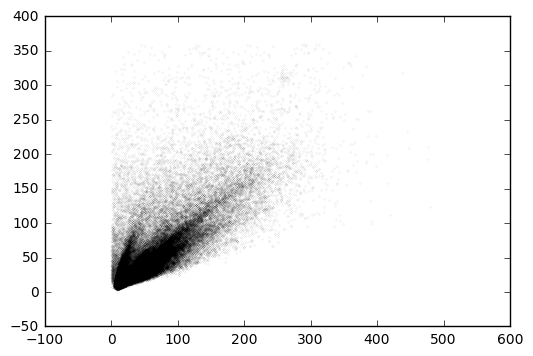

In [53]:

import matplotlib.pyplot as plt
%matplotlib inline 

plt.scatter([box_shape[i][0] for i in range(len(box_shape))],[box_shape[i][1] for i in range(len(box_shape))], s = 0.005, marker = '.')

In [35]:
'''
Created on Feb 20, 2017

@author: jumabek
'''
from os import listdir
from os.path import isfile, join
import argparse
import cv2
import numpy as np
import sys
import os
import shutil
import random 
import math
import json

width_in_cfg_file = 416.
height_in_cfg_file = 416.

def IOU(x,centroids):
    similarities = []
    k = len(centroids)
    for centroid in centroids:
        c_w,c_h = centroid
        w,h = x
        if c_w>=w and c_h>=h:
            similarity = w*h/(c_w*c_h)
        elif c_w>=w and c_h<=h:
            similarity = w*c_h/(w*h + (c_w-w)*c_h)
        elif c_w<=w and c_h>=h:
            similarity = c_w*h/(w*h + c_w*(c_h-h))
        else: #means both w,h are bigger than c_w and c_h respectively
            similarity = (c_w*c_h)/(w*h)
        similarities.append(similarity) # will become (k,) shape
    return np.array(similarities) 

def avg_IOU(X,centroids):
    n,d = X.shape
    sum = 0.
    for i in range(X.shape[0]):
        #note IOU() will return array which contains IoU for each centroid and X[i] // slightly ineffective, but I am too lazy
        sum+= max(IOU(X[i],centroids)) 
    return sum/n

def write_anchors_to_file(centroids,X,anchor_file):
    f = open(anchor_file,'w')
    
    anchors = centroids.copy()
    print(anchors.shape)

    for i in range(anchors.shape[0]):
        anchors[i][0]*=width_in_cfg_file/32.
        anchors[i][1]*=height_in_cfg_file/32.
         

    widths = anchors[:,0]
    sorted_indices = np.argsort(widths)

    print('Anchors = ', anchors[sorted_indices])
        
    for i in sorted_indices[:-1]:
        f.write('%0.2f,%0.2f, '%(anchors[i,0],anchors[i,1]))

    #there should not be comma after last anchor, that's why
    f.write('%0.2f,%0.2f\n'%(anchors[sorted_indices[-1:],0],anchors[sorted_indices[-1:],1]))
    
    f.write('%f\n'%(avg_IOU(X,centroids)))

def kmeans(X,centroids,eps,anchor_file):
    
    N = X.shape[0]
    iterations = 0
    k,dim = centroids.shape
    prev_assignments = np.ones(N)*(-1)    
    iter = 0
    old_D = np.zeros((N,k))

    while True:
        D = [] 
        iter+=1           
        for i in range(N):
            d = 1 - IOU(X[i],centroids)
            D.append(d)
        D = np.array(D) # D.shape = (N,k)
        
        print ("iter {}: dists = {}".format(iter,np.sum(np.abs(old_D-D))))
            
        #assign samples to centroids 
        assignments = np.argmin(D,axis=1)
        
        #if (assignments == prev_assignments).all() :
        #    print("Centroids = ",centroids)            
        #    write_anchors_to_file(centroids,X,anchor_file)
        #    return

        if (assignments == prev_assignments).all() :
            print("Centroids = ",centroids)            
            return centroids
        
        #calculate new centroids
        centroid_sums=np.zeros((k,dim),np.float)
        for i in range(N):
            centroid_sums[assignments[i]]+=X[i]        
        for j in range(k):            
            centroids[j] = centroid_sums[j]/(np.sum(assignments==j))
        
        prev_assignments = assignments.copy()     
        old_D = D.copy()  



In [36]:
num_clusters = 9
eps = 0.005
box_shape = np.array(box_shape)
anchor_file = 'anchors.txt'
indices = [ random.randrange(box_shape.shape[0]) for i in range(num_clusters)]
centroids = box_shape[indices] # randomly initialized the centroid to elements in the set
centroids = kmeans(box_shape,centroids,eps,anchor_file)

iter 1: dists = 576650.2378938112
iter 2: dists = 53016.694545855025
iter 3: dists = 29442.75837352885
iter 4: dists = 20323.571423469028
iter 5: dists = 14218.55022277202
iter 6: dists = 10127.759550178862
iter 7: dists = 7323.244935275586
iter 8: dists = 5787.00926925403
iter 9: dists = 4996.479909474251
iter 10: dists = 4465.600578509888
iter 11: dists = 3955.723260151598
iter 12: dists = 3711.844371028267
iter 13: dists = 3599.055417180923
iter 14: dists = 3296.157371207276
iter 15: dists = 3023.536100766823
iter 16: dists = 2959.635597945827
iter 17: dists = 2752.3432046493144
iter 18: dists = 2497.379224457455
iter 19: dists = 2475.6689596677106
iter 20: dists = 2396.1741418511237
iter 21: dists = 2261.6739223807913
iter 22: dists = 2216.839467752844
iter 23: dists = 2068.794116625892
iter 24: dists = 2008.185397324807
iter 25: dists = 1868.386395891367
iter 26: dists = 1825.7721883709314
iter 27: dists = 1820.491718324632
iter 28: dists = 1717.0471972736866
iter 29: dists = 1664

[array([0.54772542, 0.60795297]), array([1.24203594, 1.1330562 ]), array([2.27821192, 1.69218289]), array([3.22386949, 3.22392679]), array([5.66950174, 4.92887942])]


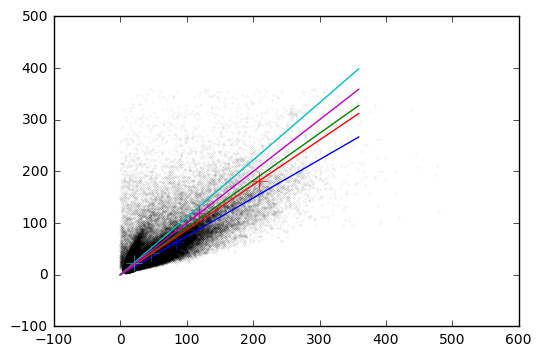

In [42]:
import numpy as np
# For 416x416 images anchor box should be between [0 to 13], because 416/32 = 13
img_width = 480
img_height = 480
width_in_cfg_file = 416
anchors_run1 = np.array([[ 84.11859391, 62.48059889],
 [ 45.85978864,  41.8359212 ],
 [209.33544883, 181.98939407],
 [ 20.22370778,  22.44749422],
 [119.03518113, 119.03729681]])


import matplotlib.pyplot as plt
%matplotlib inline 
f = plt.figure()
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
plt.scatter([box_shape[i][0] for i in range(len(box_shape))],[box_shape[i][1] for i in range(len(box_shape))], s = 0.005, marker = '.')
X = list(range(360))
for i in range(anchors_run1.shape[0]):
    plt.plot(X, np.multiply(X,1.*anchors_run1[i][1]/anchors_run1[i][0]),color = c[i])
    plt.plot(anchors_run1[i][0],anchors_run1[i][1], markersize=12 , marker = '+', color = c[i])

for i in range(anchors_run1.shape[0]):
    anchors_run1[i][0]*=width_in_cfg_file/480. # rescale to input images size 416
    anchors_run1[i][1]*=width_in_cfg_file/480.
    anchors_run1[i][0]/=32. 
    anchors_run1[i][1]/=32.
print(sorted(anchors_run1, key = lambda x: x[1])) 

In [85]:
anchors_run2 = np.array([[136.51134673, 111.27001078],
 [ 78.669171,    75.00685743],
 [ 47.89625292, 38.61094355],
 [ 20.05567117,  22.84915965],
 [204.05708251, 191.71262056]])
for i in range(anchors_run1.shape[0]):
    anchors_run2[i][0]*=width_in_cfg_file/480. # rescale to input images size 416
    anchors_run2[i][1]*=width_in_cfg_file/480.
    anchors_run2[i][0]/=32. 
    anchors_run2[i][1]/=32.
print(sorted(anchors_run2, key = lambda x: x[1])) 

[[3.69718231 3.01356279]
 [2.13062338 2.03143572]
 [1.29719018 1.04571305]
 [0.54317443 0.61883141]
 [5.52654598 5.19221681]]


[array([0.39788518, 0.51267565]), array([0.8582806 , 0.67417279]), array([1.40511672, 1.01954274]), array([2.07484186, 1.57227249]), array([0.64116229, 2.00708268]), array([3.15946796, 2.31490638]), array([4.50985573, 3.6472283 ]), array([1.78326528, 3.96075677]), array([5.95163536, 5.79801817])]


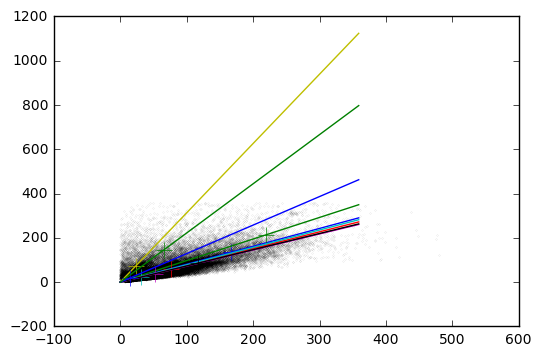

In [40]:
import numpy as np
# For 416x416 images anchor box should be between [0 to 13], because 416/32 = 13
img_width = 480
img_height = 480
width_in_cfg_file = 416
anchors_run3 = np.array([[166.51774989, 134.66689102],
 [219.75269009, 214.08067085],
 [ 76.6095457,   58.05313821],
 [ 31.69036079,  24.89253361],
 [ 51.88123273,  37.64465494],
 [ 23.67368465,  74.10766804],
 [116.65727864,  85.47346639],
 [ 14.69114508,  18.92956259],
 [ 65.84364105, 146.24332675]])


import matplotlib.pyplot as plt
%matplotlib inline 
f = plt.figure()
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k','b','g','r','c']
plt.scatter([box_shape[i][0] for i in range(len(box_shape))],[box_shape[i][1] for i in range(len(box_shape))], s = 0.005, marker = '.')
X = list(range(360))
for i in range(anchors_run3.shape[0]):
    plt.plot(X, np.multiply(X,1.*anchors_run3[i][1]/anchors_run3[i][0]),color = c[i]) # slope 
    plt.plot(anchors_run3[i][0],anchors_run3[i][1], markersize=12 , marker = '+', color = c[i]) #centroid

    # The anochor value put in cofigure file if the input image is resized to width_in_cfg_file
for i in range(anchors_run3.shape[0]):
    anchors_run3[i][0]*=width_in_cfg_file/480. # rescale to input images size 416
    anchors_run3[i][1]*=width_in_cfg_file/480.
    anchors_run3[i][0]/=32. 
    anchors_run3[i][1]/=32.
print(sorted(anchors_run3, key = lambda x: x[1]))    